In [10]:
import numpy as np
import os
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import random
import seaborn as sns
%matplotlib inline
from scipy.cluster.hierarchy import fcluster
import h5py
from io import StringIO
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans

import xlsxwriter as Excel

In [11]:
#converts to df to binary dataframe, 0 representing that the previous value was 0, and 1 indicating a nonzero value
def df_to_binary(df_expression):    
    temp = df_expression
    num_rows = len(temp)
    for c in range(len(df_expression.columns)):
        nonzero_inds = df_expression.iloc[:,c].to_numpy().nonzero()[0]
        temp_col = np.zeros(num_rows)
        temp_col[nonzero_inds] = 1
        temp.iloc[:,c] = temp_col
    return(temp)



#INPUTS:
#  file_list: list of csv filenames containing expression data. Will concatenate these matrices together and compute distances
def preprocess_samples(file_list):
    sample_source = []
    # Merge all of the files into one dataframe
    df_expression = pd.read_csv(os.path.join(data_path,file_list[0]),index_col = 0,sep="\t")
    sample_source.extend(np.repeat(file_list[0],len(df_expression.columns)))
    for filename in file_list[1:]:
        temp = pd.read_csv(os.path.join(data_path,filename),index_col = 0, sep = "\t")
        sample_source.extend(np.repeat(filename,len(temp.columns)))
        df_expression = df_expression.merge(temp,right_index=True,left_index=True)
    
    df_expression.columns = pd.Series(df_expression.columns)
    df_expression.index = pd.Series(df_expression.index)
    
    return(df_expression,sample_source)    

In [12]:
def normalize(X):
    return (X - np.mean(X,axis=1).reshape(X.shape[0],1))/np.linalg.norm((X - np.mean(X,axis=1).reshape(X.shape[0],1)),ord=2,axis=1).reshape(X.shape[0],1)

In [13]:
def normalize_and_transpose(file_list, gene_list):
    df_expression_raw,sample_source = preprocess_samples(file_list)
    df_expression_raw = df_expression_raw.astype(float)
    df_expression_raw_trans = np.transpose(df_expression_raw)
    df_expression_norm_trans = pd.DataFrame(normalize(np.transpose(np.array(df_expression_raw))),columns=list(df_expression_raw.index)
, index = list(df_expression_raw))
    df_expression_norm = np.transpose(df_expression_norm_trans)
    return df_expression_raw, df_expression_norm, df_expression_raw_trans, df_expression_norm_trans, sample_source

In [14]:
def elbow_method(data):
    distortions = []
    labels_from_iterations = []
    for i in range(1, 11):
        km = KMeans(
            n_clusters=i, init='k-means++',
            n_init=10, max_iter=300,
            tol=1e-04, random_state=0
        )
        km.fit(data)
        label = km.predict(data)
        distortions.append(km.inertia_)
        labels_from_iterations.append(label)

    # plot
    plt.figure()
    plt.plot(range(1, 11), distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.show()
    return labels_from_iterations

In [15]:
def kmeans(data, n):
    km = KMeans(
    n_clusters=n, init='k-means++',
    n_init=10, max_iter=300, 
    tol=1e-04, random_state=0
    )
    km.fit(data)
    centroids = km.cluster_centers_
    cluster_assignments = km.predict(data)
    return cluster_assignments, centroids

In [16]:
#INPUTS: 
#  h5filepath: path where the full matrix is stored with meta and expression data
#  subsamples: a pandas DataFrame that must contain a column (foreign key) called SampleGeoAccession
#OUTPUT
#  merged dataframe of length(subsamples) merged with relevant meta/Sample values for cluster analysis
def h5_sample_meta_lookup(h5filepath,subsamples,sample_source):
    f = h5py.File(h5filepath, 'r')
    full_data = pd.DataFrame({"Description":f[("meta/Sample_description")], 
                          "Characteristics":f[("meta/Sample_characteristics_ch1")],
                          "SampleGeoAccession":f[("meta/Sample_geo_accession")],
                          "Series ID":f[("meta/Sample_series_id")],
                          "Molecule":f["meta/Sample_molecule_ch1"],
                          "Source Name":f["meta/Sample_title"]})
    f.close()
    full_data["SampleGeoAccession"] = full_data["SampleGeoAccession"].apply(lambda x : x.decode("utf-8"))
    cluster_meta = subsamples.merge(full_data,on="SampleGeoAccession",how="left")
    cluster_meta["Sample_Label"] = pd.Series(sample_source).str.replace(".csv","").str.replace("_expression"," ")
    cluster_meta["Series ID"] = cluster_meta["Series ID"].str.decode("utf-8").str.replace("Xx","").str.replace("xX","")
    cluster_meta["Molecule"] = cluster_meta["Molecule"].str.decode("utf-8")
    cluster_meta["Source Name"] = cluster_meta["Source Name"].str.decode("utf-8")
    cluster_meta["Description"] = cluster_meta["Description"].str.decode("utf-8").str.replace("Xx","").str.replace("xX","")
    cluster_meta["Characteristics"] = cluster_meta["Characteristics"].str.decode("utf-8").str.replace("Xx","").str.replace("xX","")
    return(cluster_meta)

In [107]:
sample_source

['ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',


In [17]:
def purity_to_excel(cluster_metadata_metrics, outfile):
    workbook = Excel.Workbook("tables/" +outfile +".xlsx")
    worksheet = workbook.add_worksheet()
    cluster_format = workbook.add_format({'bold': True, 'align':'center'})
    center = workbook.add_format({'align': 'center'})

    # Add a format. Light red fill with dark red text.
    format1 = workbook.add_format({'bg_color': '#FFC7CE',
                                   'font_color': '#9C0006'})

    # Add a format. Green fill with dark green text.
    format2 = workbook.add_format({'bg_color': '#C6EFCE',
                                   'font_color': '#006100'})

    worksheet.write('A1', "Cluster ID",cluster_format)
    worksheet.write('B1', "Cluster Size",center)
    worksheet.write('C1', "Dominant Molecule",center)
    worksheet.write('D1', "Molecule Purity",center)
    worksheet.write('E1', "Dominant Series",center)
    worksheet.write('F1', "Series Purity",center)
    worksheet.write('G1', "Dominant Label",center)
    worksheet.write('H1', "Label Purity",center)

    worksheet.set_column(1, 7, 15)

    num_keys = len(list(cluster_metadata_metrics.keys()))
    
    j = 1
    for i in np.sort(list(cluster_metadata_metrics.keys())):
        worksheet.write(j,0,i,center)
        worksheet.write(j,1,cluster_metadata_metrics[i]["Size"],center)
        worksheet.write(j,2,list(cluster_metadata_metrics[i]["Molecule Purity"].keys())[0],center)
        worksheet.write(j,3,list(cluster_metadata_metrics[i]["Molecule Purity"].values())[0],center)
        worksheet.write(j,4,list(cluster_metadata_metrics[i]["Series Purity"].keys())[0],center)
        worksheet.write(j,5,list(cluster_metadata_metrics[i]["Series Purity"].values())[0],center)
        worksheet.write(j,6,list(cluster_metadata_metrics[i]["Label Purity"].keys())[0],center)
        worksheet.write(j,7,list(cluster_metadata_metrics[i]["Label Purity"].values())[0],center)
        j += 1

    # Write a conditional format over a range.
    worksheet.conditional_format('H2:H'+str(num_keys+1), {'type': 'cell',
                                             'criteria': '>=',
                                             'value': 0.8,
                                             'format': format2})

    # Write another conditional format over the same range.
    worksheet.conditional_format('H2:H'+str(num_keys+1), {'type': 'cell',
                                             'criteria': '<',
                                             'value': 0.8,
                                             'format': format1})



    workbook.close()

In [70]:
data_path = "samples"
#converts to df to binary dataframe, 0 representing that the previous value was 0, and 1 indicating a nonzero value
def df_to_binary(df_expression):    
    temp = df_expression.copy()
    num_rows = len(temp)
    for c in range(len(df_expression.columns)):
        nonzero_inds = df_expression.iloc[:,c].to_numpy().nonzero()[0]
        temp_col = np.zeros(num_rows)
        temp_col[nonzero_inds] = 1
        temp.iloc[:,c] = temp_col
    return(temp)



def normalize(X):
    return (X - np.mean(X,axis=1).reshape(X.shape[0],1))/np.linalg.norm((X - np.mean(X,axis=1).reshape(X.shape[0],1)),ord=2,axis=1).reshape(X.shape[0],1)


#INPUTS:
#  file_list: list of csv filenames containing expression data. Will concatenate these matrices together and compute distances
def preprocess_samples(file_list):
    sample_source = []
    # Merge all of the files into one dataframe
    df_expression = pd.read_csv(os.path.join(data_path,file_list[0]),index_col = 0,sep="\t")
    sample_source.extend(np.repeat(file_list[0],len(df_expression.columns)))
    for filename in file_list[1:]:
        temp = pd.read_csv(os.path.join(data_path,filename),index_col = 0, sep = "\t")
        sample_source.extend(np.repeat(filename,len(temp.columns)))
        df_expression = df_expression.merge(temp,right_index=True,left_index=True)
    
    df_expression.columns = pd.Series(df_expression.columns)
    df_expression.index = pd.Series(df_expression.index)
    
    return(df_expression,sample_source)    

def hierarchical_clustering(df,title,method="average",metric="euclidean"):
    clustering = shc.linkage(df, method=method, metric=metric)
    plt.figure(figsize=(25, 20))  
    plt.title(title)  

    dend = shc.dendrogram(clustering) 
    print("Cophenet = " + str(cophenet(clustering, pdist(df))[0]))
    return(clustering)

#INPUTS: 
#  h5filepath: path where the full matrix is stored with meta and expression data
#  subsamples: a pandas DataFrame that must contain a column (foreign key) called SampleGeoAccession
#OUTPUT
#  merged dataframe of length(subsamples) merged with relevant meta/Sample values for cluster analysis
def h5_sample_meta_lookup(h5filepath,subsamples):
    f = h5py.File(h5filepath, 'r')
    full_data = pd.DataFrame({"Description":f[("meta/Sample_description")], 
                          "Characteristics":f[("meta/Sample_characteristics_ch1")],
                          "SampleGeoAccession":f[("meta/Sample_geo_accession")],
                          "Series ID":f[("meta/Sample_series_id")],
                          "Molecule":f["meta/Sample_molecule_ch1"],
                          "Source Name":f["meta/Sample_title"]})
    f.close()
    full_data["SampleGeoAccession"] = full_data["SampleGeoAccession"].apply(lambda x : x.decode("utf-8"))
    cluster_meta = subsamples.merge(full_data,on="SampleGeoAccession",how="left")
    cluster_meta["Sample_Label"] = pd.Series(sample_source).str.replace(".csv","").str.replace("_expression"," ")
    cluster_meta["Series ID"] = cluster_meta["Series ID"].str.decode("utf-8").str.replace("Xx","").str.replace("xX","")
    cluster_meta["Molecule"] = cluster_meta["Molecule"].str.decode("utf-8")
    cluster_meta["Source Name"] = cluster_meta["Source Name"].str.decode("utf-8")
    cluster_meta["Description"] = cluster_meta["Description"].str.decode("utf-8").str.replace("Xx","").str.replace("xX","")
    cluster_meta["Characteristics"] = cluster_meta["Characteristics"].str.decode("utf-8").str.replace("Xx","").str.replace("xX","")
    return(cluster_meta)

def purity_to_excel(cluster_metadata_metrics, H0, outfile):
    workbook = Excel.Workbook("tables/" +outfile +".xlsx")
    worksheet = workbook.add_worksheet()
    cluster_format = workbook.add_format({'bold': True, 'align':'center'})
    center = workbook.add_format({'align': 'center'})

    # Add a format. Light red fill with dark red text.
    format1 = workbook.add_format({'bg_color': '#FFC7CE',
                                   'font_color': '#9C0006'})

    # Add a format. Green fill with dark green text.
    format2 = workbook.add_format({'bg_color': '#C6EFCE',
                                   'font_color': '#006100'})

    worksheet.write('A1', "Cluster ID",cluster_format)
    worksheet.write('B1', "Cluster Size",center)
    worksheet.write('C1', "Dominant Molecule",center)
    worksheet.write('D1', "Molecule Purity",center)
    worksheet.write('E1', "Dominant Series",center)
    worksheet.write('F1', "Series Purity",center)
    worksheet.write('G1', "Dominant Label",center)
    worksheet.write('H1', "Label Purity",center)
    worksheet.write('I1', "Null Hypothesis Value",center)

    worksheet.set_column(1, 7, 15)

    num_keys = len(list(cluster_metadata_metrics.keys()))

    j = 1
    for i in np.sort(list(cluster_metadata_metrics.keys())):
        worksheet.write(j,0,i,center)
        worksheet.write(j,1,cluster_metadata_metrics[i]["Size"],center)
        worksheet.write(j,2,list(cluster_metadata_metrics[i]["Molecule Purity"].keys())[0],center)
        worksheet.write(j,3,list(cluster_metadata_metrics[i]["Molecule Purity"].values())[0],center)
        worksheet.write(j,4,list(cluster_metadata_metrics[i]["Series Purity"].keys())[0],center)
        worksheet.write(j,5,list(cluster_metadata_metrics[i]["Series Purity"].values())[0],center)
        worksheet.write(j,6,list(cluster_metadata_metrics[i]["Label Purity"].keys())[0],center)
        worksheet.write(j,7,list(cluster_metadata_metrics[i]["Label Purity"].values())[0],center)
        worksheet.write(j,8,H0[list(cluster_metadata_metrics[i]["Label Purity"].keys())[0]],center)
        
        

        # Write a conditional format over a range.
        worksheet.conditional_format('H'+str(j+1), {'type': 'cell',
                                             'criteria': '>=',
                                             'value': H0[list(cluster_metadata_metrics[i]["Label Purity"].keys())[0]],
                                             'format': format2})

        # Write another conditional format over the same range.
        worksheet.conditional_format('H'+str(j+1), {'type': 'cell',
                                             'criteria': '<',
                                             'value': H0[list(cluster_metadata_metrics[i]["Label Purity"].keys())[0]],
                                             'format': format1})

        j += 1

    workbook.close()


def get_purity(cluster_assignments, df_expression_trans,cluster_title):
    cluster_dict = {"SampleGeoAccession":[],"ClusterAssignment":[]}
    cluster_dict["SampleGeoAccession"] = df_expression_trans.index
    cluster_dict["ClusterAssignment"] = cluster_assignments
    cluster_info = pd.DataFrame(cluster_dict)
    cluster_metadata = h5_sample_meta_lookup("human_matrix.h5",cluster_info).sort_values("ClusterAssignment")
    
    #hypothesized values of expected sample frequencies assuming no separation (based on observed proportion of sample labels)
    H0 = {}
    for samp in cluster_metadata.Sample_Label:
        H0[samp] = len(cluster_metadata[cluster_metadata.Sample_Label == samp])/len(cluster_metadata)
    
    cluster_metadata_metrics = {}
    for c in range(1,k+1):
        cluster_metadata_metrics[c] = {"Size":len(cluster_metadata.loc[cluster_metadata.ClusterAssignment == c]), 
                                       "Molecule Purity":{},"Series Purity":{},"Label Purity":{}}
        series_counts = cluster_metadata.groupby('ClusterAssignment')["Series ID"].value_counts()
        molecule_counts = cluster_metadata.groupby('ClusterAssignment')["Molecule"].value_counts()
        label_counts = cluster_metadata.groupby('ClusterAssignment')["Sample_Label"].value_counts()

        series_purity_key = pd.DataFrame(series_counts[c][series_counts[c] == series_counts[c].max()]).index[0]
        series_purity_val = series_counts[c].max()/float(series_counts[c].sum())
        cluster_metadata_metrics[c]["Series Purity"][series_purity_key] = round(series_purity_val,3)

        molecule_purity_key = pd.DataFrame(molecule_counts[c][molecule_counts[c] == molecule_counts[c].max()]).index[0]
        molecule_purity_val = molecule_counts[c].max()/float(molecule_counts[c].sum())
        cluster_metadata_metrics[c]["Molecule Purity"][molecule_purity_key] = round(molecule_purity_val,3)

        label_purity_key = pd.DataFrame(label_counts[c][label_counts[c] == label_counts[c].max()]).index[0]
        label_purity_val = label_counts[c].max()/float(label_counts[c].sum())
        cluster_metadata_metrics[c]["Label Purity"][label_purity_key] = round(label_purity_val,3)
    purity_to_excel(cluster_metadata_metrics,H0,cluster_title+" purity")

my project folder stores the downloaded data samples in a folder called **samples**

In [72]:
data_path = "samples"

In [73]:
def main(data, sample_source, n, file_names, data_name):
    cluster_assignments = labels[n-1]
    assignments_to_purity(cluster_assignments,sample_source, n, file_names + '_' + data_name + '_kmeans_' + str(k))

In [96]:
file_list = ["ALPHA_expression.csv","beta_expression.csv","PANC1_expression.csv"]
df_expression_raw, df_expression_norm, df_expression_raw_trans, df_expression_norm_trans, sample_source = normalize_and_transpose(file_list, gene_list)

In [99]:
# Results from gene shaving
gene_list = ['ARNTL', 'CERS5', 'DDR1', 'GJA4', 'HNRNPA3P15', 'SLC27A2']
df_extracted = df_expression_norm_trans[gene_list]

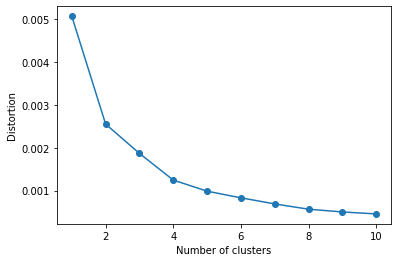

In [100]:
labels = elbow_method(df_extracted)

In [101]:
k = 3

In [102]:
cluster_assignments = labels[k-1]

In [103]:
cluster_assignments

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 2, 2, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 1,
       2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2,

In [111]:
def sortDF(df, cluster_assignments, outfile):
    sample_list_sorted = []
    
    
    for i in np.unique(cluster_assignments):
        for j in list(df.index[cluster_assignments == i]):
            sample_list_sorted.append(j)
    df.loc[sample_list_sorted,:].to_csv(outfile) 
    
    return(sample_source_sorted)

In [115]:
sample_source_sorted = []
for i in np.unique(cluster_assignments):
    for j in list(df_extracted.index[cluster_assignments == i]):
        for k in range(len(df_extracted.index)):
            if(df_extracted.index[k] == j):
                sample_source_sorted.append(sample_source[k].replace(""))
            
            

In [116]:
sample_source_sorted

['ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'beta_expression.csv',
 'beta_expression.csv',
 'beta_expression.csv',
 'beta_expression.csv',
 'beta_expression.csv',
 'beta_expression.csv',
 'beta_expression.csv',
 'beta_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_expression.csv',
 'ALPHA_

In [112]:
sortDF(df_extracted, cluster_assignments, "whoop")

TypeError: list indices must be integers or slices, not str

In [39]:
np.mean(df_expression_norm_trans.iloc[0,:])

5.0190963971163516e-18

In [40]:
df_expression_norm_trans

,A1BG,A1CF,A2M,A2ML1,A2MP1,A3GALT2,A4GALT,A4GNT,AAAS,AACS,...,BP-21201H5.1,BP-21264C1.1,BP-2168N6.1,BP-2168N6.3,BP-2171C21.2,BP-2171C21.4,BP-2171C21.5,BP-2171C21.6,BP-2189O9.2,YR211F11.2
GSM1093235,-1.282595e-04,-0.000123,-0.000159,-0.000159,-0.000159,-0.000159,-0.000159,-0.000154,-0.000159,-0.000128,...,-0.000154,-0.000159,-0.000159,-0.000159,-0.000159,-0.000159,-0.000159,-0.000152,-0.000159,-0.000159
GSM1093236,-1.370438e-04,-0.000126,-0.000168,-0.000157,-0.000168,-0.000168,-0.000054,-0.000168,-0.000144,-0.000068,...,-0.000167,-0.000168,-0.000168,-0.000168,-0.000168,-0.000168,-0.000168,-0.000168,-0.000168,-0.000168
GSM1649207,-7.111114e-06,0.001797,-0.000175,-0.000175,-0.000214,-0.000214,-0.000208,-0.000215,-0.000031,0.000418,...,-0.000177,-0.000190,-0.000215,-0.000215,-0.000213,-0.000215,-0.000215,-0.000215,-0.000192,-0.000215
GSM1649201,-2.473749e-05,0.000931,-0.000136,-0.000137,-0.000151,-0.000158,-0.000156,-0.000158,-0.000020,0.000368,...,-0.000101,-0.000155,-0.000158,-0.000158,-0.000150,-0.000158,-0.000153,-0.000157,-0.000149,-0.000158
GSM1649199,1.373817e-05,0.001515,-0.000134,-0.000181,-0.000222,-0.000224,-0.000226,-0.000227,-0.000078,0.000551,...,-0.000188,-0.000225,-0.000228,-0.000228,-0.000225,-0.000228,-0.000224,-0.000228,-0.000228,-0.000225
GSM1649206,-3.116886e-06,0.000990,0.000183,-0.000197,-0.000234,-0.000235,-0.000192,-0.000235,-0.000128,0.000442,...,-0.000226,-0.000234,-0.000235,-0.000235,-0.000235,-0.000235,-0.000235,-0.000234,-0.000172,-0.000235
GSM1649198,-3.338538e-05,0.000226,-0.000105,-0.000098,-0.000112,-0.000112,-0.000110,-0.000113,-0.000059,0.000165,...,-0.000097,-0.000105,-0.000113,-0.000114,-0.000112,-0.000114,-0.000112,-0.000112,-0.000106,-0.000112
GSM1649205,-4.785633e-05,0.000854,-0.000139,-0.000168,-0.000186,-0.000186,-0.000186,-0.000186,-0.000089,0.000182,...,-0.000167,-0.000179,-0.000186,-0.000186,-0.000185,-0.000186,-0.000186,-0.000186,-0.000173,-0.000186
GSM1649204,-7.748427e-05,0.000791,0.000081,-0.000175,-0.000188,-0.000189,-0.000186,-0.000189,0.000003,0.000042,...,-0.000178,-0.000186,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,-0.000189,-0.000188,-0.000189
GSM1649208,-1.851139e-05,0.001711,-0.000124,-0.000203,-0.000263,-0.000250,-0.000256,-0.000263,-0.000169,0.000883,...,-0.000231,-0.000245,-0.000265,-0.000265,-0.000259,-0.000265,-0.000263,-0.000265,-0.000220,-0.000259


In [41]:
#Let X be N (genes) x P (samples) expression matrix (pandas dataframe)
def gene_shave(df):
    #clusters where clusterID (key) also represents the size k, values are a list of inds of genes belonging to cluster
    S = {}
    xbarSk = {}
    #remove rows of all zeros
    df_nonzero = df[(df.T != 0).any()]
    genes = np.array(df_nonzero.index)
    samples = list(df_nonzero.columns)
    X = np.array(df_nonzero)
    X = (X - np.mean(X,axis=1).reshape(X.shape[0],1))/np.linalg.norm((X - np.mean(X,axis=1).reshape(X.shape[0],1)),ord=2,axis=1).reshape(X.shape[0],1)
    X_copy = X.copy()
    while(X_copy.shape[0] > 1):
        corr = np.corrcoef(np.transpose(X_copy))
        w,v = np.linalg.eig(corr)
        #leading principal component is vmax
        vmax = v[0]
        dot_prods = np.dot(X_copy,vmax)
        dot_prods_argsort = np.argsort(dot_prods)
        #save the inds of top 90% of rows with respect to dot product with vmax
        top90perc = np.where(dot_prods_argsort > len(dot_prods_argsort)*0.1)[0]
        S[len(top90perc)] = genes[top90perc]
        xbarSkhat = np.mean(X_copy[top90perc,:],axis=0)
        xbarSk[len(top90perc)] = xbarSkhat
        #remove the bottom 10% of X_copy's rows with respect to dot product with vmax
        X_copy = X_copy[top90perc,:]
        genes = genes[top90perc]
    return(S,xbarSk)

In [ ]:
S, xbarSk = gene_shave(df)

In [ ]:
def Dk(df,S,k,xbar):
    Dks = []
    sumVw = 0.0
    sumVb = 0.0
    #sum over p columns
    jcnt = 0
       
    for j in df.columns: 
        #sum over each gene in Sk
        #print("OK" + str(xbar.shape))
        sumVw = np.sum((df.loc[:,j] - xbar[jcnt])**2)
        #or i in S[k]:
        #    sumVw += (df.loc[i,j] - xbar[jcnt])**2
        sumVb = np.sum((xbar[jcnt] - 0)**2)
        jcnt += 1
    Vw = sumVw/(k*len(df.columns))
    Vb = sumVb/len(df.columns)
    Vt = Vw+Vb
    Dks.append((Vb/Vw)/(1+(Vb/Vw)))
    return(Dks[0])

def findK(S, xbarSk, df):
    
    Gapk = {}
    Dks = {}
    for k in S:
        print(k)
        D_k = Dk(df.loc[S[k],:],S,k,xbarSk[k])
        #D_k_b = Dk(df,k,5)
        Dks[k] = (D_k)
    return(Dks)

In [ ]:
#find the optimum value of k based on R^2 values. Choose the value of k with the highest value
X = np.array(df)
X = (X - np.mean(X,axis=1).reshape(X.shape[0],1))/np.linalg.norm((X - np.mean(X,axis=1).reshape(X.shape[0],1)),ord=2,axis=1).reshape(X.shape[0],1)
df_norm = pd.DataFrame(X,index=df.index,columns=df.columns)
findK(S, xbarSk , df_norm)